<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/220215_exp_12_transformer_chatbot_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**12. 트랜스포머로 만드는 대화형 챗봇**

**STEP 1. 데이터 수집하기**

폴더 만들고 raw data 가져오기

In [100]:
# !mkdir -p ~/aiffel/transformer_chatbot/data/

In [101]:
# Chatbotdata.csv 파일은 직접 폴더로 옮김

In [102]:
# 각종 필요한 라이브러리 import
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

데이터의 구성 확인

In [103]:
from google.colab import files
uploaded = files.upload()

Saving ChatbotData.csv to ChatbotData (1).csv


In [104]:
import io
train_data = pd.read_csv(io.BytesIO(uploaded['ChatbotData.csv']))

In [105]:
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [106]:
train_data.tail()

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


상위, 하위 각각 5개의 샘플을 출력해보니, 일상적인 대화에 대한 단답형 문답으로 이루어져 있었다.

In [107]:
print(len(df))

11823


총 샘플의 개수는 11,823개 이다.

**STEP 2. 데이터 전처리하기 (한국어 데이터)**

In [108]:
# 1. 데이터 전처리에서 일단 Null 값(결측 데이터)을 확인한다.

In [109]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


다행히도 Null값은 존재하지 않아서 null값 처리가 필요하지 않았다.

문장에서 단어와 구두점 사이에 공백을 추가하여 다른 문자와 구분하는 방식으로 진행한다. (단순히 제거하는 방법도 有)

In [110]:
# 정규 표현식 사용!
questions = []
for sentence in train_data['Q']:
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [111]:
answers = []
for sentence in train_data['A']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [112]:
# 상위 10개만 출력하여 띄어쓰기를 통해 분리 되었는지 확인
print(questions[:10])
print(answers[:10])


['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네', 'SD카드 망가졌어', 'SD카드 안돼', 'SNS 맞팔 왜 안하지ㅠㅠ', 'SNS 시간낭비인 거 아는데 매일 하는 중', 'SNS 시간낭비인데 자꾸 보게됨']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .', '다시 새로 사는 게 마음 편해요 .', '다시 새로 사는 게 마음 편해요 .', '잘 모르고 있을 수도 있어요 .', '시간을 정하고 해보세요 .', '시간을 정하고 해보세요 .']


복잡한 기호나, 특수 문자등이 없어서 전처리는 이정도 까지만 하면 충분한 것 같다.

**STEP 3. SubwordTextEncoder 사용하기**
(SubwordTextEncoder 사용)

단어장(Vocabulary) 만들기

In [113]:
import tensorflow_datasets as tfds # tensorflow 내장 데이터셋 부르는 용도
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [114]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [115]:
print('시작 토큰 Num :',START_TOKEN)
print('종료 토큰 Num :',END_TOKEN)
print('단어 집합 Size :',VOCAB_SIZE)

시작 토큰 Num : [8178]
종료 토큰 Num : [8179]
단어 집합 Size : 8180


In [116]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[22]))) # 임의로 선택한 22번 질문!

임의의 질문 샘플을 정수 인코딩 : [389, 811, 40, 413, 2]


각 단어에 고유한 정수가 부여된 Voca를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인 할수 있다.

Questions와 Answers에 대해서 전부 정수 인코딩을 수행한다.

문장의 최대 길이를 정하고 해당 길이로 패딩한다.


In [117]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [118]:
questions, answers = tokenize_and_filter(questions, answers)


In [119]:
print('Questions size :', questions.shape)
print('Answers size :', answers.shape)

Questions size : (11823, 40)
Answers size : (11823, 40)


In [120]:
# 0번 샘플을 임의로 출력
print(questions[0])
print(answers[0]) 

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


Maxlen (40)에 맞추기 위해 뒤에 0이 패딩된 것을 볼 수 있다. 

교사 강요(teacher forcing)란, 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법입니다. 훈련할 때 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블. 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용

In [121]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.


BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용.
# 이에 따라 outputs에서는 START_TOKEN을 제거.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 마지막 패딩 토큰 제거 길이 39가 된다.
    },
    {
        'outputs': answers[:, 1:] # 맨처음 토큰이 제거 길이가 39가 된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

**STEP 4. 모델 구성하기 (Transformer 생성)**

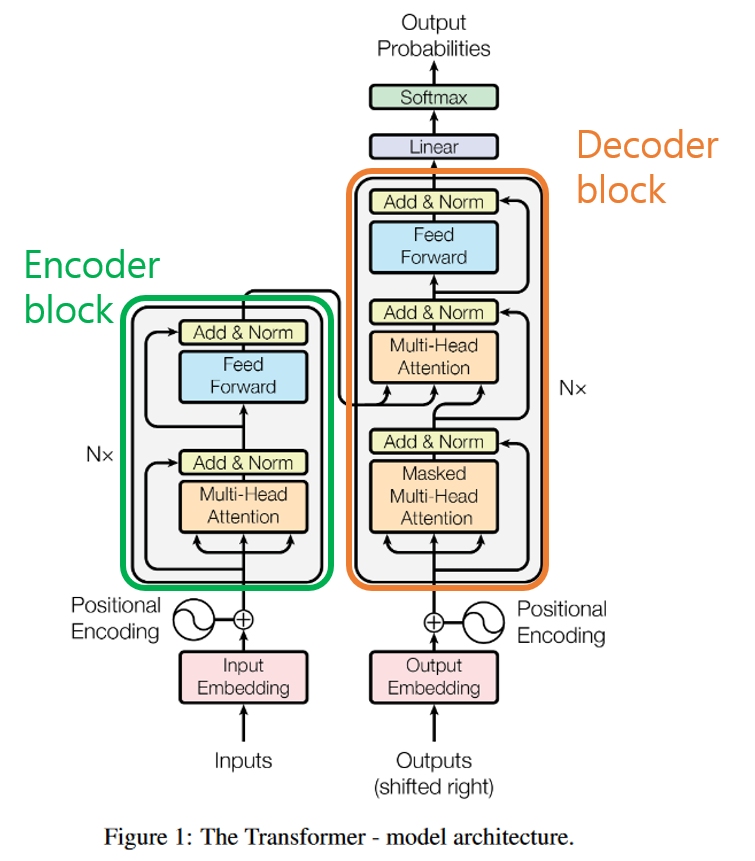

가장 어려운 부분으로 쉽게 비유를 하자면 차량 엔진에서 나오는 동력을 미세 조정하여 출력값으로 내뿜는 기어와 같은 구조의 모델이라고 보면된다.

기어 계수의 비가 안맞거나 톱니가 하나라도 어긋나면 동작하지 않거나 심각한 결함으로 망가져 버리는 그러한 구조라는 생각이 들었다.

포지셔널 행렬 구현

In [122]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

스케일드 닷 프로덕트 어텐션 함수 구현

In [123]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

멀티 헤드 어텐션 구현

In [124]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

패딩 마스킹 구현

In [125]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

룩 어헤드 마스킹 ( 다음 단어 가리기 ) 구현

In [126]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [127]:
# transformer 함수 정의
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용.
  # 내부적으로 패딩 마스크도 포함.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


인코더 층 구현

In [128]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

인코더 만들기

In [129]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [130]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

디코더 층 구현

In [131]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

디코더 만들기

In [132]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [157]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)


In [158]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3148288     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

손실 함수 정의 

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용.

In [160]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

딥러닝 모델 학습시에 learning rate는 매우 중요한 hyperparameter다. 

좋은 학습률을 찾는 한 가지 방법은 매우 낮은 학습률 (예를 들면 10^-5) 에서 시작해서 점진적으로 매우 큰 학습률 (예를 들면 10)까지 수백 번 반복하여 모델을 훈련하는 것이다. 반복마다 일정한 값을 학습률에 곱한다. 로그 스케일로 조정된 학습률을 사용하여 학습률에 대한 손실을 그래프로 그리면 처음에 손실이 줄어드는 것이 보인다. 하지만 잠시 후 학습률이 커지면 손실이 다시 커진다. 최적의 학습률은 손실이 다시 상승하는 지점보다 조금 아래에 있을 것이다. 일반적으로 상승점보다 약 10배 낮은 지점이라고 한다. 그 다음 모델을 다시 초기화하고 앞에서 찾은 학습률을 사용하여 다시 정상적으로 훈련


출처: https://eehoeskrap.tistory.com/445 [Enough is not enough]



여태껏 learning rate 같은 경우에는 위의 내용을 일일이 다 할수 없어서 각각의 optimizer에서 기본적으로 setting 된 값을 사용하거나, 검색후 모델별로 최적화된 값들을 적용하였는데, 최근에는 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급기법을 널리 사용하고 있다.

이러한 방법을 커스텀 학습률 스케쥴링이라고 한다.


In [161]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

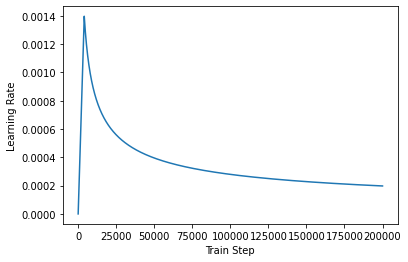

In [162]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

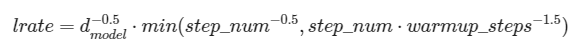

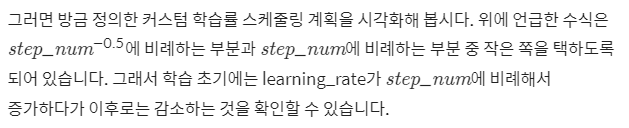

모델 컴파일 하기.

In [163]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [164]:
EPOCHS = 50  # 에포크 50을 학습
hist = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 16s 53ms/step - loss: 1.4595 - accuracy: 0.0272
Epoch 2/50
185/185 [==============================] - 10s 53ms/step - loss: 1.1826 - accuracy: 0.0494
Epoch 3/50
185/185 [==============================] - 10s 53ms/step - loss: 1.0048 - accuracy: 0.0506
Epoch 4/50
185/185 [==============================] - 10s 53ms/step - loss: 0.9300 - accuracy: 0.0542
Epoch 5/50
185/185 [==============================] - 10s 53ms/step - loss: 0.8726 - accuracy: 0.0574
Epoch 6/50
185/185 [==============================] - 10s 53ms/step - loss: 0.8143 - accuracy: 0.0613
Epoch 7/50
185/185 [==============================] - 10s 53ms/step - loss: 0.7491 - accuracy: 0.0672
Epoch 8/50
185/185 [==============================] - 10s 53ms/step - loss: 0.6769 - accuracy: 0.0748
Epoch 9/50
185/185 [==============================] - 10s 53ms/step - loss: 0.5972 - accuracy: 0.0836
Epoch 10/50
185/185 [==============================] - 10s 53ms/step - loss: 0.514

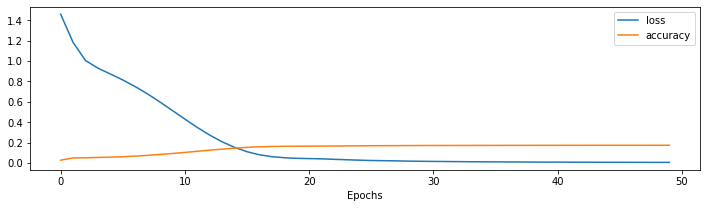

In [165]:
hist.history

plt.figure(figsize=(12,3))
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.xlabel('Epochs')
plt.legend(['loss', 'accuracy'])

**STEP 5. 모델 평가하기**

STEP 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만들기

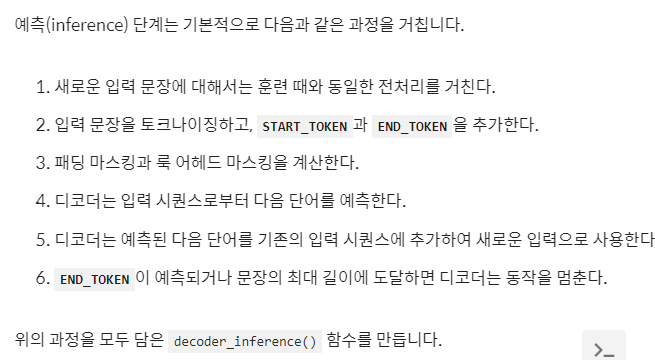

In [166]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [167]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가
    # 이 output_sequence는 다시 디코더의 입력이 된다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [168]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('질문 : {}'.format(sentence))
  print('대답 : {}'.format(predicted_sentence))

  return predicted_sentence

모델 평가하기

In [177]:
output_sequence = sentence_generation('한숨만 나온다.')

질문 : 한숨만 나온다.
대답 : 잘 찾아보세요 .


In [182]:
output_sequence = sentence_generation('에휴')

질문 : 에휴
대답 : 제가 있잖아요 .


In [183]:
output_sequence = sentence_generation('너 죽고 싶냐?')

질문 : 너 죽고 싶냐?
대답 : 상대방이 예의가 없네요 .


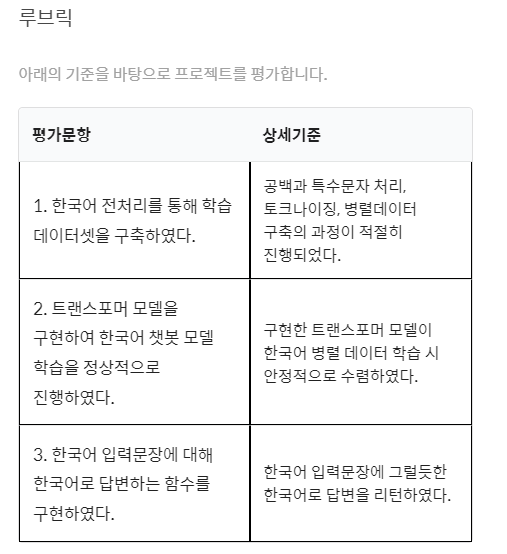

1번 과정과 2번 과정은 안정적으로 진행이 되었으나, 3번 기준에서는 그럴듯하게는 리턴이 되나, 계속 질문을 하니 동문서답이 나올때가 많았다.

loss값은 줄어들지만, accuracy는 epoch가 진행되어도 17%에 수렴을 하고 더 이상 높아지지 않는데, overfitting이 되었고, 기존의 데이터로 학습을 진행하는데 뭔가 한계가 있는거 같아 보인다.

좀더 찾아봐야겠고 이번에 exp같은 경우에는 앞에서도 언급했지만, 기어 구조를 해부하여 기계적으로 맞추는 느낌이 들었다.

사실 아직까지 완벽하게 트랜스포머에 대한 이해가 있다고 말은 못하겠다.

추가적으로

1. Custom learning rate scheduling

2. 딥러닝 교과서와 같이 전반적인 순환 신경망 개선법에 대해서 전부 정리

3. 논문을 보고 구현할수 있는 실력을 기르도록 영어 공부

이렇게 해야 함을 절실히 느꼈다.

cv쪽으로 향후 더 깊게 배우겠지만, 자연어처리 연구에서 많은 모델들이 나오고 cv쪽에서도 활용을 할수 있는 만큼 정리가 필요하다고 느꼈다.

GAN도 복습이 필요하다. 현재까지 배운것중에는 오늘한것과 이 둘이 끝판왕이 아닌가 싶다.
